In [ ]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


IMG_SIZE = 224  
BATCH_SIZE = 16
EPOCHS = 50
DATASET_PATH = r'DataTranning'  


def load_data():
    X, y = [], []
    for label, cls in enumerate(['good', 'error']):
        path = os.path.join(DATASET_PATH, cls, '*')
        for img_path in glob.glob(path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

X, y = load_data()
X = X / 255.0  


In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(f'Class weights: {class_weights}')


Class weights: {0: 0.8125, 1: 1.3}


In [ ]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  

In [ ]:

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("\n✅ Model Summary:")
model.summary()


✅ Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5385 - loss: 0.8581

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5385 - loss: 0.8581 - val_accuracy: 0.5000 - val_loss: 0.6095
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5385 - loss: 0.5222

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - accuracy: 0.5385 - loss: 0.5222 - val_accuracy: 0.7500 - val_loss: 0.5154
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7692 - loss: 0.5828

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step - accuracy: 0.7692 - loss: 0.5828 - val_accuracy: 1.0000 - val_loss: 0.4486
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6923 - loss: 0.4999

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step - accuracy: 0.6923 - loss: 0.4999 - val_accuracy: 1.0000 - val_loss: 0.4071
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.7692 - loss: 0.4531

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 0.7692 - loss: 0.4531 - val_accuracy: 1.0000 - val_loss: 0.3606
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6154 - loss: 0.6364

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step - accuracy: 0.6154 - loss: 0.6364 - val_accuracy: 1.0000 - val_loss: 0.3299
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6923 - loss: 0.4773

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step - accuracy: 0.6923 - loss: 0.4773 - val_accuracy: 1.0000 - val_loss: 0.3011
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8462 - loss: 0.4349

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8462 - loss: 0.4349 - val_accuracy: 1.0000 - val_loss: 0.2758
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9231 - loss: 0.3214

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9231 - loss: 0.3214 - val_accuracy: 1.0000 - val_loss: 0.2536
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8462 - loss: 0.4371

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step - accuracy: 0.8462 - loss: 0.4371 - val_accuracy: 1.0000 - val_loss: 0.2361
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8462 - loss: 0.3857

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step - accuracy: 0.8462 - loss: 0.3857 - val_accuracy: 1.0000 - val_loss: 0.2278
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6923 - loss: 0.4327

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step - accuracy: 0.6923 - loss: 0.4327 - val_accuracy: 1.0000 - val_loss: 0.2207
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8462 - loss: 0.3468

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step - accuracy: 0.8462 - loss: 0.3468 - val_accuracy: 1.0000 - val_loss: 0.2103
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8462 - loss: 0.3028

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step - accuracy: 0.8462 - loss: 0.3028 - val_accuracy: 1.0000 - val_loss: 0.1958
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8462 - loss: 0.3382

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - accuracy: 0.8462 - loss: 0.3382 - val_accuracy: 1.0000 - val_loss: 0.1796
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 1.0000 - loss: 0.2279

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - accuracy: 1.0000 - loss: 0.2279 - val_accuracy: 1.0000 - val_loss: 0.1677
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9231 - loss: 0.2364

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step - accuracy: 0.9231 - loss: 0.2364 - val_accuracy: 1.0000 - val_loss: 0.1592
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9231 - loss: 0.2293

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step - accuracy: 0.9231 - loss: 0.2293 - val_accuracy: 1.0000 - val_loss: 0.1520
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9231 - loss: 0.2028

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9231 - loss: 0.2028 - val_accuracy: 1.0000 - val_loss: 0.1466
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9231 - loss: 0.2734

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step - accuracy: 0.9231 - loss: 0.2734 - val_accuracy: 1.0000 - val_loss: 0.1387
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 1.0000 - loss: 0.2054

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step - accuracy: 1.0000 - loss: 0.2054 - val_accuracy: 1.0000 - val_loss: 0.1319
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8462 - loss: 0.2929

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - accuracy: 0.8462 - loss: 0.2929 - val_accuracy: 1.0000 - val_loss: 0.1248
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9231 - loss: 0.2349

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step - accuracy: 0.9231 - loss: 0.2349 - val_accuracy: 1.0000 - val_loss: 0.1193
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - accuracy: 0.9231 - loss: 0.1721 - val_accuracy: 1.0000 - val_loss: 0.1203
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step - accuracy: 1.0000 - loss: 0.1288 - val_accuracy: 1.0000 - val_loss: 0.1304
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step - accuracy: 0.9231 - loss: 0.2392 - val_accuracy: 1.0000 - val_loss: 0.1424
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.8462 - loss: 0.2916 - val_accuracy: 1.0000 - val_loss: 0.1411
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.9231 - loss: 0.2740 - val_accuracy: 1.0000 - val_loss: 0.1314


In [3]:

y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, zero_division=1))


TEST_PATH = r'DataTest'
test_images = glob.glob(os.path.join(TEST_PATH, '*'))

for img_path in test_images:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0][0]
    label = 'ERROR' if pred >= 0.5 else 'GOOD'
    print(f'{os.path.basename(img_path)} => {label} ({pred:.4f})')

NameError: name 'model' is not defined

In [2]:
import matplotlib.pyplot as plt


def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Biểu đồ Loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Biểu đồ Accuracy
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

plot_history(history)


NameError: name 'history' is not defined

In [6]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))

for i, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb / 255.0
    img_norm = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_norm)[0][0]
    label = 'ERROR' if pred >= 0.5 else 'GOOD'

    axes[i].imshow(img_rgb)
    axes[i].set_title(f"{label} ({pred:.4f})")
    axes[i].axis('off')

plt.show()


NameError: name 'test_images' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
0.jpg => GOOD (0.0495)


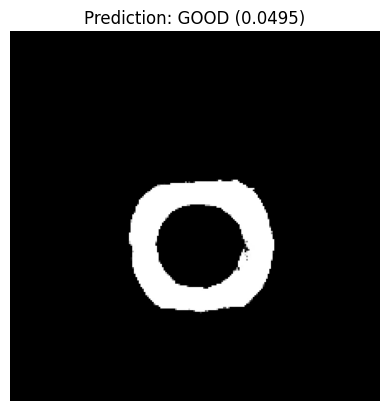

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1.jpg => GOOD (0.0486)


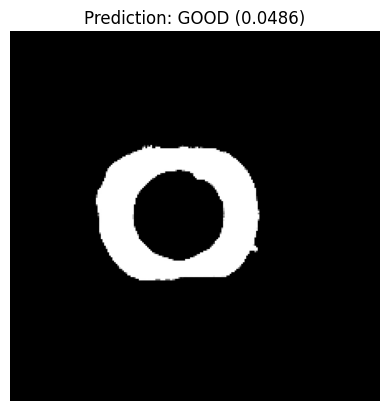

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
6.jpg => ERROR (0.8603)


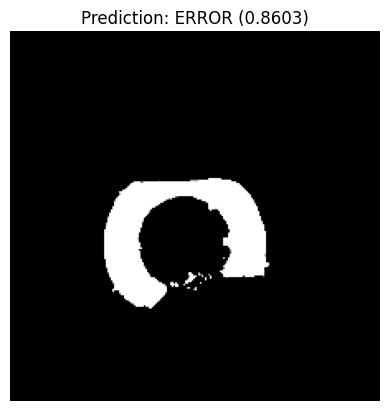

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
7.jpg => ERROR (0.9873)


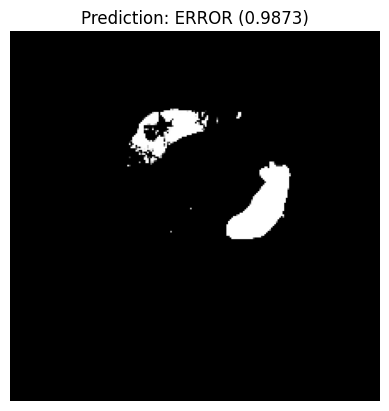

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
image.png => ERROR (0.9894)


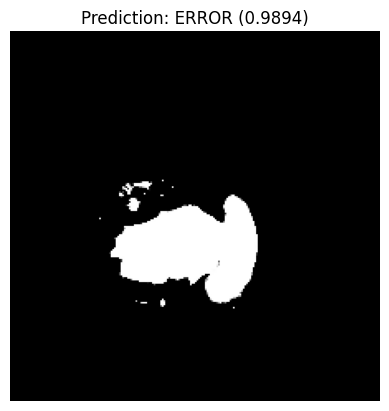

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

IMG_SIZE = 224  
MODEL_PATH = "best_resnet_model.h5"  
TEST_PATH = "DataTest"  

model = load_model(MODEL_PATH)

test_images = glob.glob(os.path.join(TEST_PATH, "*"))

for img_path in test_images:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img_norm = img / 255.0  
    img_input = np.expand_dims(img_norm, axis=0)  

    pred = model.predict(img_input)[0][0]
    label = "ERROR" if pred >= 0.5 else "GOOD"
    
    print(f"{os.path.basename(img_path)} => {label} ({pred:.4f})")
    
    # Hiển thị ảnh với nhãn dự đoán
    plt.imshow(img)
    plt.title(f"Prediction: {label} ({pred:.4f})")
    plt.axis("off")
    plt.show()


In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import load_model
import RS304MD  # Thư viện điều khiển động cơ

# Khai báo các thông số
IMG_SIZE = 224  
MODEL_PATH = "best_resnet_model.h5"  
TEST_PATH = "DataTest"  
ID = 2  # ID của động cơ
THOIGIAN_DICHUYEN = 100  # Thời gian di chuyển của động cơ

# Load mô hình
model = load_model(MODEL_PATH)
rs = RS304MD.Rs()

def mocongCOM():
    rs.open_port('COM3', 115200, 1)
    print('Kết nối COM3 thành công!')
    rs.torque_on(ID, 1)
    print('Enable Force Successfull!')

def dongcongCOM():
    rs.torque_on(ID, 0)
    rs.close_port()
    print('Hủy kết nối COM3 thành công!')

def chayrobot(gocdichuyen):
    print(f'Di chuyển đến góc {gocdichuyen} độ')
    rs.target_position(ID, gocdichuyen * 10, THOIGIAN_DICHUYEN)
    time.sleep(1)

def main():
    mocongCOM()
    
    test_images = glob.glob(os.path.join(TEST_PATH, "*"))
    
    for img_path in test_images:
        # Đọc và xử lý ảnh
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_norm = img / 255.0
        img_input = np.expand_dims(img_norm, axis=0)
        
        # Dự đoán
        pred = model.predict(img_input)[0][0]
        label = "ERROR" if pred >= 0.5 else "GOOD"
        print(f"{os.path.basename(img_path)} => {label} ({pred:.4f})")
        
        # Hiển thị ảnh
        plt.imshow(img)
        plt.title(f"Prediction: {label} ({pred:.4f})")
        plt.axis("off")
        plt.show()
        
        # Điều khiển động cơ
        if label == "ERROR":
            chayrobot(90)
        else:
            chayrobot(-90)
        chayrobot(0)  # Quay về vị trí ban đầu
    
    dongcongCOM()

if __name__ == "__main__":
    print("Nguyễn Đăng Khoa 211604294")
    main()